# Outlet Allocation program

The result at whole dataset:


In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from time import time

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.metrics import classification_report, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import missingno as msno

# Create sample files

In [2]:
outlet_file = r'data_input3\OutletBook_v1_7.xlsx'
coordinate_file = r'data_input3\Coordinates active outlets.xlsx'

In [ ]:
# The defense from Run All action
# The function below is very time-consuming
assert False

In [41]:
def create_sample_files():
    """ Creates sample input files for developing purposes """
    # Remove dupes and non-active outlets, then save a fraction of data in 10%
    df_outlet = pd.read_excel(outlet_file, skiprows=0)
    # Exclude inactive outlets
    df_outlet_sample = df_outlet[df_outlet['Активность точки']==2].sample(frac=0.1, random_state=42)
    print(f"Number of outlets: {df_outlet_sample.shape}")
    with pd.ExcelWriter(r'data_input3\OutletBook_sample.xlsx') as writer: # pylint: disable=abstract-class-instantiated
        df_outlet_sample.to_excel(writer, sheet_name='Sheet1', index=False)
    # Leave only used outlets in coord file
    df_coor = pd.read_excel(coordinate_file)
    df_coor_sample = df_coor[df_coor['OL_ID'].isin(df_outlet_sample['OL_id'])]
    with pd.ExcelWriter(r'data_input3\Coordinates_sample.xlsx') as writer: # pylint: disable=abstract-class-instantiated
        df_coor_sample.to_excel(writer, sheet_name='Sheet1', index=False)

create_sample_files()

Number of outlets: (45767, 73)


# Loading and merge data

In [3]:
# outlet_file = r'data_input3\OutletBook_sample.xlsx'
# coordinate_file = r'data_input3\Coordinates_sample.xlsx'

In [4]:
# Read coordinates
coordinates = pd.read_excel(coordinate_file)

# Retain trade outlets with coordinates in Russia
coordinates = coordinates[(coordinates['Latitude']>40)&(coordinates['Latitude']<82)]
coordinates = coordinates[((coordinates['Longitude']>=10)&(coordinates['Longitude']<180)) | \
    ((coordinates['Longitude']>=-180)&(coordinates['Longitude']<-160))]
print(f'The amount of trade outlet with GPS: {coordinates.shape[0]}')

The amount of trade outlet with GPS: 296051


In [5]:
# Read outlets
outlets = pd.read_excel(outlet_file)
# Exclude inactive outlets
outlets = outlets[outlets['Активность точки']==2]
print(f"Total outlets: {outlets.shape[0]}")

Total outlets: 319962


In [6]:
# Merging dataframes by outlet code
df = outlets.merge(coordinates, how='left', left_on='OL_id', right_on='OL_ID')

# Getting some features, rename, and custom sort
df = df[['OL_id','OLName','OLDeliveryAddress','#TC',
         '(АК) СубЪект РФ','(АК) Район\Город','(АК) Населенный пункт','(АК) Улица','(АК) Номер дома',
         'FFDH (Регион)','FFDL (Area)','Ответственный сотрудник','Код сотрудника',
         'Network_id','Network_Name','NetworkTypeName', 'Тип ТТ (MWC)',
         'Latitude','Longitude']]
df.columns = ['SWE_Store_Key','Outlet_Name','Delivery_Address','Sync_Id',
              'Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4','Kladr_level_5',
              'FFDH_Region','FFDL_Area','Responsible','Responsible_Id',
              'Chain_Id','Chain_Name','Chain_Type','Outlet_Type',
              'Latitude','Longitude']
df = df[['SWE_Store_Key','Outlet_Name','Delivery_Address','Sync_Id',
         'Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4','Kladr_level_5',
         'Chain_Id','Chain_Name','Chain_Type','Outlet_Type','Latitude','Longitude',
         'Responsible_Id','Responsible','FFDH_Region','FFDL_Area']]

# Restoring coordinates

In [7]:
# There are NaN Kladr fields. Using Sync_Id as th high level
df['Sync_Id'] = df['Sync_Id'].astype(str)
df['Kladr_level_1'].fillna('Нет данных', inplace=True)
df['Kladr_level_2'].fillna('Нет данных', inplace=True)
df['Kladr_level_3'].fillna('Нет данных', inplace=True)
df['Kladr_level_4'].fillna('Нет данных', inplace=True)
df['Kladr_level_5'].fillna('Нет данных', inplace=True)

In [8]:
def get_avg_coordinate_by_kladr(row, kladr_grouped):
    """
    Return average coordinate by Kladr levels

    Parameters:
    -----------
    row (Series): ['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4'] locality for getting coordinate
    kladr_grouped (Series with Multiindex (['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4']):
        contains coordinate for 4-level locality

    Returns:
    --------
    float: coordinate

    """
    try:
        return kladr_grouped[row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3'],row['Kladr_level_4']]
    except KeyError:
        try:
            return kladr_grouped[row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3']].mean()
        except KeyError:
            try:
                return kladr_grouped[row['Kladr_level_1'],row['Kladr_level_2']].mean()
            except KeyError:
                try:
                    return kladr_grouped[row['Kladr_level_1']].mean()
                except KeyError:
                    text = f"Cannot get average coordinate for the locality {row['Kladr_level_1']}, " \
                        f"{row['Kladr_level_2']}, {row['Kladr_level_3']}, {row['Kladr_level_4']}"
                    print(text)
                    return 0
                
def get_avg_coordinate_by_sync(row, sync_grouped):
    """
    Return average coordinate by sync id

    Parameters:
    -----------

    Returns:
    --------
    float: coordinate

    """
    try:
        return sync_grouped[row['Sync_Id']]
    except KeyError:
        text = f"Cannot get average coordinate for point of sync id {row['Sync_Id']}"
        print(text)
        return 0
                
def restore_coordinate_part(part_name):
    try:
        t0 = time()
        # Series with MultiIndex and seeking by Kladr
        kladr_grouped = df[(df['isCoord']==1)&(df['isKladr']==1)]. \
            groupby(['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4'])[part_name].mean()
        df.loc[(df['isCoord']==0)&(df['isKladr']==1),part_name] = \
            df.loc[(df['isCoord']==0)&(df['isKladr']==1)] \
            [['SWE_Store_Key','Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4']].apply( \
            get_avg_coordinate_by_kladr, args=(kladr_grouped,), axis=1)
        # Series with index and seeking by Sync_Id
        sync_grouped = df[df['isCoord']==1]. \
            groupby(['Sync_Id'])[part_name].mean()
        df.loc[(df['isCoord']==0)&(df['isKladr']==0),part_name] = \
            df.loc[(df['isCoord']==0)&(df['isKladr']==0)] \
            [['SWE_Store_Key','Sync_Id']].apply( \
            get_avg_coordinate_by_sync, args=(sync_grouped,), axis=1)
    except Exception as err:
        print(f"restore_coordinate_part: {err}")
    finally:
        print(f"{part_name} restoring finished in {time() - t0:.3f} sec. " \
            f"(not found {df[df[part_name]==0].shape[0]})")

def restore_coordinates():
    """ Find coordinates for an outlet by its neighbors """
    df['Latitude'].replace(0, np.NaN, inplace=True)
    df['Longitude'].replace(0, np.NaN, inplace=True)
    df['isCoord'] = ~( (df['Latitude'].isna()) | (df['Longitude'].isna()) )
    df['isKladr'] = ~( df['Kladr_level_1']=='Нет данных')
    # Restore Latitude
    restore_coordinate_part('Latitude')
    # Restore Longitude
    restore_coordinate_part('Longitude')
#     # remove unnecessary fields
#     df.drop(['Kladr_level_2','Kladr_level_3','Kladr_level_4','Kladr_level_5'],
#                  axis=1, inplace=True)

restore_coordinates()

Cannot get average coordinate for the locality Эвенкийский, Байкитский, Байкит, ул Титова
Cannot get average coordinate for the locality Эвенкийский, Байкитский, Байкит, ул Пролетарского
Cannot get average coordinate for the locality Эвенкийский, Байкитский, Байкит, ул Авиаторов
Cannot get average coordinate for the locality Эвенкийский, Байкитский, Байкит, ул Школьная
Cannot get average coordinate for the locality Эвенкийский, Байкитский, Байкит, ул Пролетарского
Latitude restoring finished in 8.063 sec. (not found 5)
Cannot get average coordinate for the locality Эвенкийский, Байкитский, Байкит, ул Титова
Cannot get average coordinate for the locality Эвенкийский, Байкитский, Байкит, ул Пролетарского
Cannot get average coordinate for the locality Эвенкийский, Байкитский, Байкит, ул Авиаторов
Cannot get average coordinate for the locality Эвенкийский, Байкитский, Байкит, ул Школьная
Cannot get average coordinate for the locality Эвенкийский, Байкитский, Байкит, ул Пролетарского
Longit

In [9]:
#сводный анализ по данным
df_stats = pd.DataFrame(columns = ['column', 'values', 'number_of_unique', 'number_of_nan', '%_nan'])
tmp = pd.DataFrame()

for c in df.columns:
    tmp['column'] = [c]
    tmp['values'] = [df[c].unique()]
    tmp['number_of_unique'] = len(list(df[c].unique()))
    tmp['number_of_nan'] = df[c].isnull().sum()
    tmp['%_nan'] = round(df[c].isnull().sum() / df.shape[0] * 100, 1)
    df_stats = df_stats.append(tmp)
    
df_stats

,column,values,number_of_unique,number_of_nan,%_nan
0,SWE_Store_Key,"[100690000005804, 100050000004045, 10005000000...",319927,0,0.0
0,Outlet_Name,"[Псковпечать, ООО ""Союз Святого Иоанна Воина"" ...",240533,12,0.0
0,Delivery_Address,"[Псковская обл, Палкинский р-н, Палкино рп, ул...",289588,2,0.0
0,Sync_Id,"[69, 5, 359, 88, 147, 312, 148, 218, 348, 209,...",318,0,0.0
0,Kladr_level_1,"[Псковская, Ленинградская, Санкт-Петербург, Ма...",94,0,0.0
0,Kladr_level_2,"[Палкинский, Ломоносовский, Большелуцкая, Пско...",3031,0,0.0
0,Kladr_level_3,"[Палкино, Малое Карлино, Кингисеппский, Псков,...",18671,0,0.0
0,Kladr_level_4,"[ул Островская, ш Красносельское, тер Торговый...",28194,0,0.0
0,Kladr_level_5,"[1, 19, 6, Нет данных, 8, 11, 9, 12, 18, 10, 7...",9704,0,0.0
0,Chain_Id,"[nan, 9998.0, 2668.0, 2667.0, 50329.0, 16978.0...",3219,193479,60.5


In [10]:
# Replace NaN values
df['Outlet_Name'].fillna('Без названия', inplace=True)
df['Chain_Id'].fillna(0, inplace=True)
df['Chain_Name'].fillna('Без названия', inplace=True)
df['Chain_Type'].fillna('Без сети', inplace=True)
df['Outlet_Type'].fillna('Без типа', inplace=True)

<AxesSubplot:>

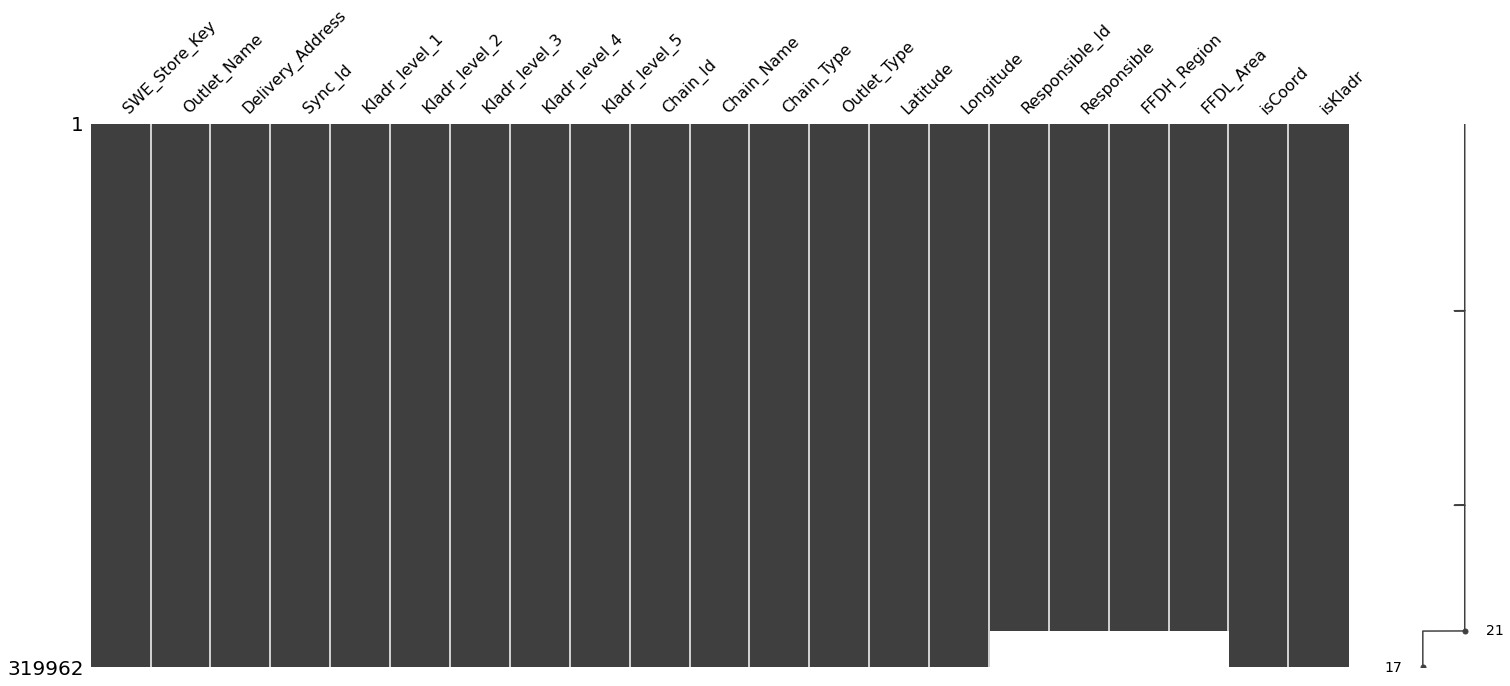

In [11]:
msno.matrix(df)

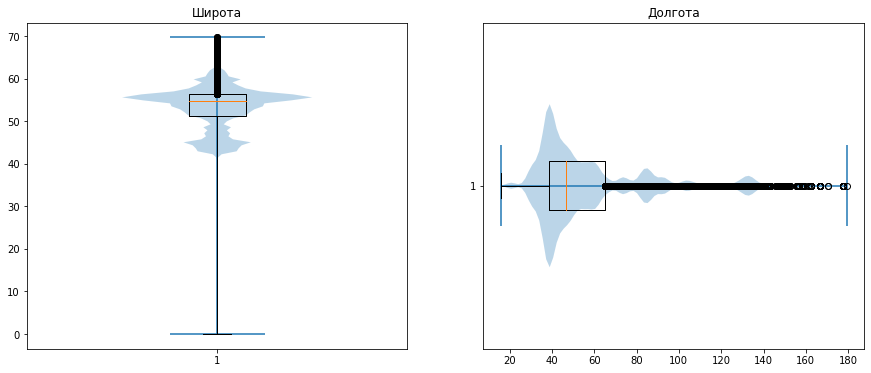

In [12]:
# Нарисовать графики типа Box & Whiskers плюс violinplot с визулальным распределением значений
fig, axes = plt.subplots(1,2, figsize=(15,6))
axes[0].violinplot(df['Latitude'].values)
axes[0].boxplot(df['Latitude'].values, whis=(0,1))
axes[0].set_title('Широта')
axes[1].violinplot(df[df['Longitude']>0]['Longitude'].values, vert=False)
axes[1].boxplot(df[df['Longitude']>0]['Longitude'].values, vert=False, whis=(0,1))
axes[1].set_title('Долгота')
plt.show()

In [13]:
df.loc[~df['Responsible_Id'].isna(),'Responsible_Id'] = \
    df.loc[~df['Responsible_Id'].isna()]['Responsible_Id'].astype('int64')

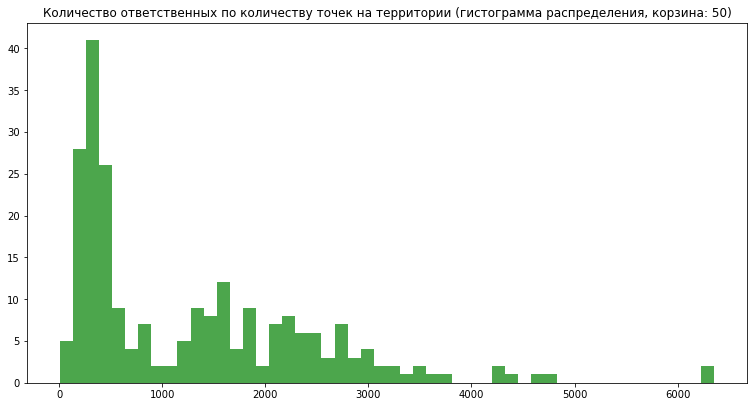

In [14]:
target = 'Responsible_Id'
# Посчитаем количество точек по классам
class_counts = df[~df[target].isna()].groupby(target).size().to_frame()
class_counts.reset_index(inplace=True)
class_counts.columns = [target,'Counts']

fig = plt.figure(figsize=(10,5))
axes = fig.add_axes([0, 0, 1, 1])
bins = 50
axes.hist(x = class_counts['Counts'].values,
        bins = bins,
        color ='green',
        alpha = 0.7)
axes.set_title(f'Количество ответственных по количеству точек на территории (гистограмма распределения, корзина: {bins})')
plt.show()

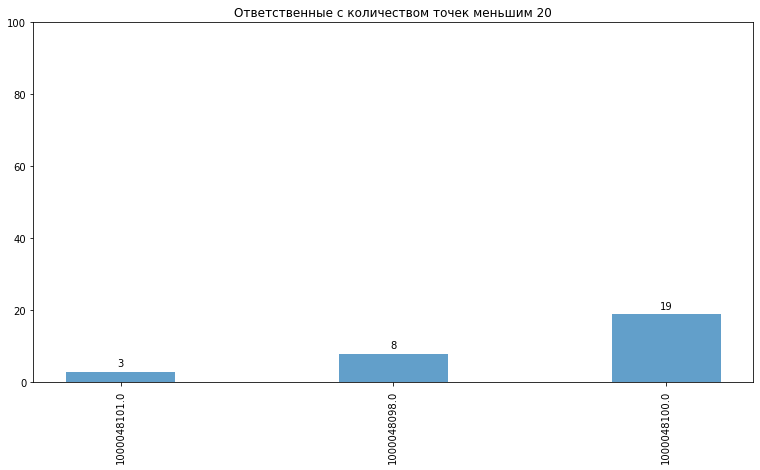

In [15]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_axes([0, 0, 1, 1])
axes.set_ylim(0, 100)
threshold = 20
df_aux = class_counts[class_counts['Counts']<threshold].sort_values('Counts', ascending=True)
rects=axes.bar(x = df_aux[target].values.astype('str'),
           height = df_aux['Counts'].values, 
           width = 0.4,
           align = 'center',
           alpha = 0.7)
for tick in axes.get_xticklabels():
    tick.set_rotation(90)
for rect in rects:
    h = rect.get_height()
    axes.annotate('%.0f' % (h),
                xy=(rect.get_x() + rect.get_width() / 2, h),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
axes.set_title(f'Ответственные с количеством точек меньшим {threshold}')
plt.show()

# Enconding

In [16]:
def X_transform(df):
    # Transform of features
    X = df[features]
    X_cat = ordinal_encoder_x.transform(X[cat_features])
    # Not transform
    X_num = X[num_features]
    # Объединить категорийные и числовые
    X_enc = np.hstack([X_cat, X_num])
    return X_enc

In [17]:
X_y = df.copy()
X_y.set_index('SWE_Store_Key',inplace=True)
X_y.drop(['isCoord'],axis=1,inplace=True)
X_y.drop(['isKladr'],axis=1,inplace=True)
X_y.drop(['Chain_Id'],axis=1,inplace=True)
X_y.drop(['Outlet_Name'],axis=1,inplace=True)
X_y.drop(['Delivery_Address'],axis=1,inplace=True)
X_y.drop(['Responsible'],axis=1,inplace=True)
X_y.drop(['FFDH_Region'],axis=1,inplace=True)
X_y.drop(['FFDL_Area'],axis=1,inplace=True)
X_y.drop(['Sync_Id'],axis=1,inplace=True)
X_y.drop(['Kladr_level_5'],axis=1,inplace=True)

In [18]:
features = X_y.iloc[:,:-1].columns
target = ''.join(X_y.iloc[:,-1:].columns)

In [19]:
ordinal_encoder_x = OrdinalEncoder()
label_encoder_y = LabelEncoder()

# Training encoders on full dataset (X & y separately)
X = X_y[features]
cat_features = X.select_dtypes(include=['object']).columns  # Categorical
num_features = X.select_dtypes(exclude=['object']).columns  # Numeric
ordinal_encoder_x.fit(X[cat_features])
y = X_y[~X_y['Responsible_Id'].isna()][target]
label_encoder_y.fit(y)

LabelEncoder()

In [20]:
# Training and prediction datasets
training = X_y[~X_y[target].isna()]
preds = X_y[X_y[target].isna()]
print(training.shape, preds.shape)

(298629, 10) (21333, 10)


In [21]:
def get_classes_to_exclude(df, threshold=2):
    """ Return a list of classes with samples less than threshold """
    if threshold < 2:
        threshold = 2
    class_counts = df[~df[target].isna()].groupby(target).size().to_frame()
    class_counts.reset_index(inplace=True)
    class_counts.columns = [target,'Counts']

    return [str(item) for item in list(class_counts[target][class_counts['Counts']<threshold].values)]

classes_to_exclude = get_classes_to_exclude(X_y, 2)

In [22]:
# Remove rows to remove from training due to small class size
training = training[~training[target].isin(classes_to_exclude)]
    
# Training-Validation split
X_train, X_valid, y_train, y_valid = \
    train_test_split(training[features], training[target],
        test_size=0.3, random_state=42, stratify=training[target])

X_training_enc = X_transform(training)
X_preds_enc = X_transform(preds)
X_train_enc = X_transform(X_train)
X_valid_enc = X_transform(X_valid)

y_training = training[target]
y_training_enc = label_encoder_y.transform(y.values.ravel())
y_train_enc = label_encoder_y.transform(y_train.values.ravel())
y_valid_enc = label_encoder_y.transform(y_valid.values.ravel())

In [23]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

In [24]:
# t0 = time()
# val_cv_score = cross_val_score(clf, X_training_enc, y_training, cv=3, scoring='balanced_accuracy')
# val_cv_score = np.array([round(item, 5) for item in val_cv_score])
# print(f"Cross-validation average score: {val_cv_score.mean():.3f}")
# # print(f"Cross-validation finished in {time() - t0:.3f} sec.")
# t0 = time()
# clf.fit(X_train_enc, y_train)
# print(f"Training finished in {time() - t0:.3f} sec.")
# t0 = time()
# y_pred = clf.predict(X_valid_enc)
# val_score = balanced_accuracy_score(y_valid, y_pred)
# print(f"Balanced accuracy score: {val_score:.3f}")
# print(f"Validation finished in {time() - t0:.1f} sec.")

In [25]:
# val_score = accuracy_score(y_valid, y_pred)
# print(f"Accuracy score: {val_score:.3f}")

The result at whole dataset
Cross-validation average score: 0.885
Training finished in 50.317 sec.
Balanced accuracy score: 0.910
Validation finished in 28.6 sec.
Accuracy score: 0.960

In [26]:
def find_top_3(X_valid):
    """ Define top 3 classes for each outlet without an answer """
    y_pred_proba = clf.predict_proba(X_valid)
    proba = pd.DataFrame(data=y_pred_proba, columns=clf.classes_)
    print(f"proba.shape {proba.shape}")

    def get_max_3_classes(row):
        """ Get n-classes array and return TOP 3 classes with maximal probability """
        ser = pd.Series(data=row.values, index=clf.classes_)
        ser.sort_values(inplace=True, ascending=False)
        return ser[0:3].index[0],ser[0:3].values[0], \
            ser[0:3].index[1],ser[0:3].values[1], \
            ser[0:3].index[2],ser[0:3].values[2]

    proba['top_1_class'], proba['top_1_proba'], \
        proba['top_2_class'], proba['top_2_proba'], \
        proba['top_3_class'], proba['top_3_proba'] = zip(*proba.apply(get_max_3_classes, axis=1))
    # inversion is needed
    proba['top_1_class'] = label_encoder_y.inverse_transform(proba['top_1_class'].values.ravel())
    proba['top_2_class'] = label_encoder_y.inverse_transform(proba['top_2_class'].values.ravel())
    proba['top_3_class'] = label_encoder_y.inverse_transform(proba['top_3_class'].values.ravel())
    # Preserve only new columns with TOP-3 classes
    proba = proba.loc[:,'top_1_class':]
    return proba

In [27]:
def get_statistics(X_valid, y_valid):
    """ Print statistics """
#     print(f"{model_description} statistics")
    proba = find_top_3(X_valid)
    # y_valid is encoded, inversion is needed
    proba['y_valid'] = label_encoder_y.inverse_transform(y_valid)
    proba['correct_1'] = proba.apply(lambda x: int(x.top_1_class==x.y_valid),axis=1)
    proba['correct_2'] = proba.apply(lambda x: int(x.top_2_class==x.y_valid),axis=1)
    proba['correct_3'] = proba.apply(lambda x: int(x.top_3_class==x.y_valid),axis=1)
    # Total predictions
    total = proba.shape[0]
    # Number of correct predictions by class
    corr_cl1 = proba[proba.top_1_class==proba.y_valid].shape[0]
    corr_cl2 = proba[proba.top_2_class==proba.y_valid].shape[0]
    corr_cl3 = proba[proba.top_3_class==proba.y_valid].shape[0]
    not_correct = total - (corr_cl1 + corr_cl2 + corr_cl3)
    print(f"""
    Total predictions: {total}
    Correct: {corr_cl1 / total * 100:.1f}% ({corr_cl1})
    Predicted in the 2nd option: {corr_cl2 / total * 100:.2f}% ({corr_cl2})
    Predicted in the 3rd option: {corr_cl3 / total * 100:.3f}% ({corr_cl3})
    Not predicted at all {not_correct / total * 100:.3f}% ({not_correct})
    """)
    
    def get_proba_info(class_num, proba_from, proba_to):
        """ Get class and return a number of correct, incorrect predictions in interval """
        correct_num = proba[(proba[class_num+'_class']==proba.y_valid)& \
            (proba[class_num+'_proba']>proba_from)&(proba[class_num+'_proba']<=proba_to)].shape[0]
        incorrect_num = proba[(proba[class_num+'_class']!=proba.y_valid)& \
            (proba[class_num+'_proba']>proba_from)&(proba[class_num+'_proba']<=proba_to)].shape[0]
        return correct_num, incorrect_num, (proba_from, proba_to)

    correct, incorrect, index = [], [], []
    for edge in range(20,100,10):
        cor, inc, ind = get_proba_info('top_1',edge/100,(edge+10)/100)
        correct.append(cor)
        incorrect.append(inc)
        index.append(ind)

    # Print out ratio of wrong and right predictions in each interval            
    a = pd.DataFrame(data={'correct':correct[::-1], 'incorrect':incorrect[::-1]}, index=index[::-1])
    top = 1
    rep_list = []
    rep_list.append(f"\n{'Interval':>12} {'Right':>8} {'Wrong':>10} {'Wrn./Tot.':>11}\n")
    for i in range(len(a)):
        mid = a.index[i][0]
        s = f"{str(a.index[i]):>12} {a.correct[i]:>8} {a.incorrect[i]:>10}"
        if i==0:
            v = a.incorrect[i] / (a.incorrect[i] + a.correct[i]) * 100
        else:
            v = a.incorrect[:i+1].sum() / (a.incorrect[:i+1].sum() + a.correct[:i+1].sum()) * 100
        rep_list.append("{0} {1:>10.2f} | interval ({2}, {3}] wrong / total = {4:.2f}%\n" \
                .format(s,
                    a.incorrect[i] / (a.incorrect[i] + a.correct[i]) * 100 if (a.incorrect[i] + a.correct[i]) > 0 else 0,
                    mid, top, v))
    print(''.join(rep_list))
    
    return proba

In [28]:
def validate():
    """ Training, Validation, Cross-Validation """
#     print(f"{model_description} validation")
    t0 = time()
    # Cross-Validation goes on full training dataset
    val_cv_score = cross_val_score(clf, X_training_enc, y_training_enc, cv=3, scoring='balanced_accuracy')
    val_cv_score = np.array([round(item, 5) for item in val_cv_score])
    print(f"Cross-validation average score: {val_cv_score.mean():.3f}")
    print(f"Cross-validation finished in {time() - t0:.3f} sec.")
    t0 = time()
    clf.fit(X_train_enc, y_train_enc)
    print(f"Training finished in {time() - t0:.3f} sec.")
    t0 = time()
    y_pred = clf.predict(X_valid_enc)
    val_score = balanced_accuracy_score(y_valid_enc, y_pred)
    print(f"Balanced accuracy score: {val_score:.3f}")
    print(f"Validation finished in {time() - t0:.1f} sec.")
    # print statistics
    proba = get_statistics(X_valid_enc, y_valid_enc)
    
    return proba

In [29]:
def fit():
    """ Training on full data set """
#     print(f"Final training {model_description}...")
    # get_encoded()
    t0 = time()
    clf.fit(X_training_enc, y_training_enc)
    print(f"Final training finished in {time() - t0:.3f} sec.")
    proba = find_top_3(X_preds_enc)

    return proba

In [30]:
# Validation
proba_valid = validate()

Cross-validation average score: 0.920
Cross-validation finished in 132.165 sec.
Training finished in 30.960 sec.
Balanced accuracy score: 0.941
Validation finished in 12.5 sec.
proba.shape (89589, 233)

    Total predictions: 89589
    Correct: 97.1% (87000)
    Predicted in the 2nd option: 2.19% (1961)
    Predicted in the 3rd option: 0.304% (272)
    Not predicted at all 0.397% (356)
    

    Interval    Right      Wrong   Wrn./Tot.
  (0.9, 1.0)    75040        381       0.51 | interval (0.9, 1] wrong / total = 0.51%
  (0.8, 0.9)     5845        280       4.57 | interval (0.8, 1] wrong / total = 0.81%
  (0.7, 0.8)     2726        352      11.44 | interval (0.7, 1] wrong / total = 1.20%
  (0.6, 0.7)     1671        467      21.84 | interval (0.6, 1] wrong / total = 1.71%
  (0.5, 0.6)     1107        571      34.03 | interval (0.5, 1] wrong / total = 2.32%
  (0.4, 0.5)      460        329      41.70 | interval (0.4, 1] wrong / total = 2.67%
  (0.3, 0.4)      123        150      54.95 

In [31]:
# Save result for analyse
X_valids = X_valid.copy()
X_valids.reset_index(inplace=True)
df_valids = pd.concat([X_valids['SWE_Store_Key'], proba_valid], axis=1,join='inner')

with pd.ExcelWriter(r'data_output3\valid_part.xlsx') as writer: # pylint: disable=abstract-class-instantiated
    df_valids.to_excel(writer, sheet_name='Sheet1', index=False)

# Final predictions

In [32]:
proba_preds = fit()

Final training finished in 37.357 sec.
proba.shape (21333, 233)


In [33]:
# Save result
X_preds = preds.iloc[:,:-1]
X_preds.reset_index(inplace=True)
# X_preds
df_preds = pd.concat([X_preds['SWE_Store_Key'], proba_preds], axis=1,join='inner')
with pd.ExcelWriter(r'data_output3\pred_part.xlsx') as writer: # pylint: disable=abstract-class-instantiated
    df_preds.to_excel(writer, sheet_name='Sheet1', index=False)